In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from src.loaders import load_data, load_labels
from src.classify import MCM_Classifier
import os
import src.plot as myplot


In [2]:
# Customizable environment variables
n_categories = 10  # Number of categories to be classified
n_variables = 121  # Number of variables in the dataset
mcm_filename_format = "train-images-unlabeled-{}_comms.dat"
data_filename_format = "train-images-unlabeled-{}.dat"
data_path = "../INPUT/data/"
communities_path = "../INPUT/MCMs/"
output_path = "../OUTPUT/"

In [3]:
print("{:-^50}".format("  MCM-Classifier  ")) 

test_data = load_data("../INPUT/data/test-images-unlabeled-all-uniform.txt").astype(int)
test_labels = load_labels("../INPUT/data/test-labels-uniform.txt").astype(int)

# Step 1: Initialize classifier
classifier = MCM_Classifier(n_categories, n_variables, mcm_filename_format, data_filename_format, data_path, communities_path)

# Step 2: Train
classifier.fit(greedy=True, max_iter=1000000, max_no_improvement=100000)


# Step 3: Evaluate
predicted_classes, probs = classifier.predict(test_data, test_labels)

# Step 4: Save classification report and other stats
# report = classifier.get_classification_report(test_labels)
classifier.save_classification_report(test_labels,path=output_path)

if (classifier.stats == None):
    raise Exception("Classifier stats not found. Did you forget to call predict()?")


----------------  MCM-Classifier  ----------------
Generating bootstrap samples...
Done!
train-images-unlabeled-0_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-1_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-2_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-3_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-4_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-5_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-6_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-7_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-8_bootstrap filename
Generating bootstrap samples...
Done!
train-images-unlabeled-9_bootstrap filename
--------------------------------------------------
--  Running MinCompSpin_SimulatedAnnealing...  ---
---------------------------

In [4]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/classifier/bin/../src/plot.py'>

In [5]:
def plot_histogram(icc_Ps, columns):
    plt.figure()
    for i in columns:
        plt.hist(icc_Ps[:, i])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of icc_Ps')
    plt.legend([f'Digit {i}' for i in columns])
    plt.show()

In [6]:
all_MCM = classifier.get_MCMs()
P =  classifier.get_P()

In [7]:
mcm_index = 3

In [8]:
# for all images in all categories, get the PDF of that all ICC of one MCM fitted to one image
all_P_icc = myplot.calculate_P_icc(P, all_MCM,mcm_index,n_variables, data_path,data_filename_format)

In [9]:
mcm3_comms_map = myplot.generate_icc_comms_map(all_MCM[mcm_index])

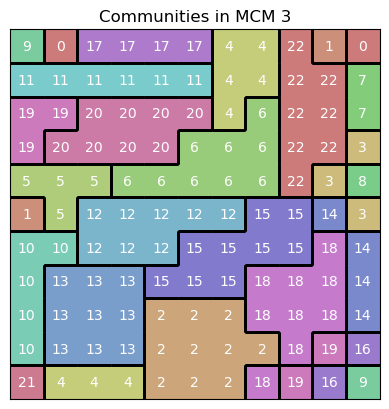

In [10]:
pastel_cmap = myplot.create_pastel_cmap(121)
borders = myplot.find_borders(mcm3_comms_map)
comms = mcm3_comms_map.astype(int) #TODO use the values here that indicate how indicative this ICC is
lw = 2
plt.figure()
plt.title("Communities in MCM 3")
myplot.draw_all_borders(borders)
myplot.draw_all_values(comms)        
plt.imshow(mcm3_comms_map, cmap=pastel_cmap)
plt.xticks([])
plt.yticks([])
plt.show()


In [11]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/classifier/bin/../src/plot.py'>

In [12]:
# difference 3 vs. 5
dif_35 = all_P_icc[:,:,[3,5]].mean(axis=1)
dif_35 = np.diff(dif_35, axis=1).flatten()

# difference in means class 3 vs. rest
dif_3r = all_P_icc.mean(axis=1)
dif_3r = dif_3r[:,3] - dif_3r.mean(axis=1)




23

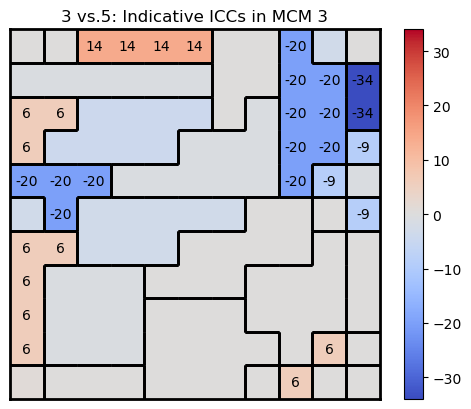

In [13]:
bias = (dif_35[comms]*100).astype(int) 
absmax = np.abs(bias.flat[np.abs(bias).argmax()]) # scale axis
# diff_map is difference in average probabilities of an ICC over all images of class 3 vs class 5
# FIXME problem is that borders are not enough to indicate which cells are the same ICC because they must not be adjacent

plt.figure()
# plt.title("Bias of ICC probabilities in MCM 3 for class 3 vs. class 5.") # plt.title(" Higher values = higher avg P for an image of class 3.")
plt.title("3 vs.5: Indicative ICCs in MCM 3")
myplot.draw_all_borders(borders)
r = (np.mean(bias)+np.std(bias))
drawing_cond = lambda x: np.abs(x) > r
myplot.draw_all_values(bias,color="black",cond=drawing_cond) # bias OR comms
white_map = myplot.create_white_cmap()
im = plt.imshow(bias, cmap="coolwarm", vmin=-absmax,vmax=absmax)  # Set the color limits
colorbar = plt.colorbar(im)

plt.xticks([])
plt.yticks([])
plt.setp(plt.gca().spines.values(), linewidth=2)

plt.show()


 Notes on possible indicativity meaures
 - in the supreme court paper by Lee, they calculate the infuence of a supereme justice by calculating e.g., mutual inforamtion(this justice, vs court)
    Option 1: MI
    - MI(own vote, majority vote)
    - for us this would be pixel vote vs. average vote of MCM
        - would need threshold for probability maybe (.5 == majority vote equivalent)
    Option 2: Suseptability Gamma (defined in text)
    

    


- 121 x 121 matrix of membership of which pixels are part of which icc could be useful but only in the new basis, right now the communities are perfectly separated

In [29]:


# comms, 11x11 matrix of integer community labels
# all_P_icc, [iccs, images, category] = [x,5k,10] where the iccs are part of 1 MCM 

from sklearn.metrics import normalized_mutual_info_score



array([0.00626413, 0.04495502, 0.        , 0.15307876, 0.        ,
       0.11991756, 0.        , 0.02941622, 0.00556224, 0.00279353,
       0.10939033, 0.        , 0.        , 0.        , 0.32585205,
       0.        , 0.02383364, 0.00604568, 0.        , 0.05804395,
       0.        , 0.05016123, 0.06174233])

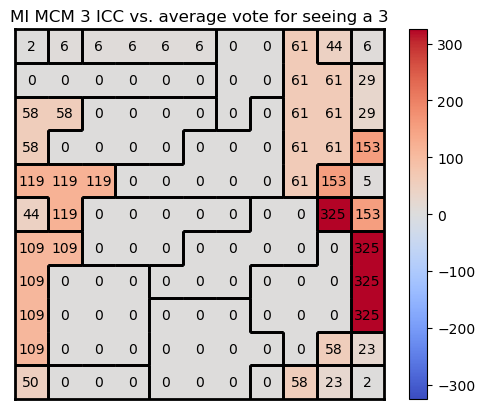

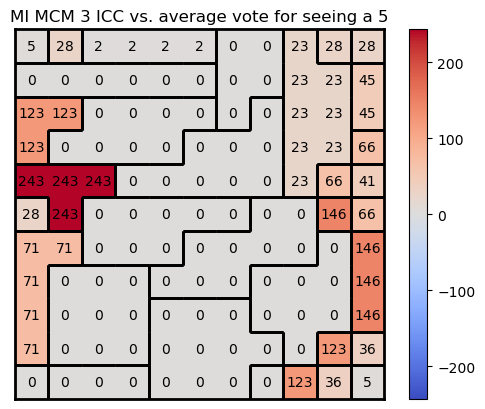

In [61]:
#  mutual information between MI(icc_vote, average_vote)
# NOTE: final MCM probability is product not sum so maybe average vote is not fair
# given a 3, calculate the MI(icc_vote, vs average vote)

for cls in [3,5]:
    P_m3_c3 = all_P_icc[:,:,cls]
    nr_comms = np.max(comms)+1
    out = np.zeros(nr_comms)
    for i in range(nr_comms):
        out[i]=normalized_mutual_info_score(np.where(P_m3_c3.mean(axis=0)>=0.5,1,0),np.where(P_m3_c3[i,:]>=0.5,1,0))
    out

    mi_matrix = (out[comms]*1000).astype(int)
    absmax = np.abs(mi_matrix.flat[np.abs(mi_matrix).argmax()])
    plt.figure()
    plt.title(f"MI MCM 3 ICC vs. average vote for seeing a {cls}")
    myplot.draw_all_borders(borders)
    # r = (np.mean(bias)+np.std(bias))
    # drawing_cond = lambda x: np.abs(x) > r
    drawing_cond = lambda x: True
    myplot.draw_all_values(mi_matrix,color="black",cond=drawing_cond) # bias OR comms
    # white_map = myplot.create_white_cmap()
    im = plt.imshow(mi_matrix, cmap="coolwarm", vmin=-absmax,vmax=absmax)  # Set the color limits
    colorbar = plt.colorbar(im)

    plt.xticks([])
    plt.yticks([])
    plt.setp(plt.gca().spines.values(), linewidth=2)

    plt.show()

# NEXT: MI of ICC vote vs correct vote

/Users/paulhosek/opt/anaconda3/envs/mcm_classifying/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


0.0

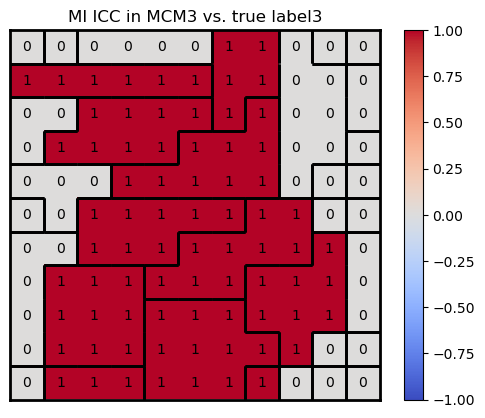

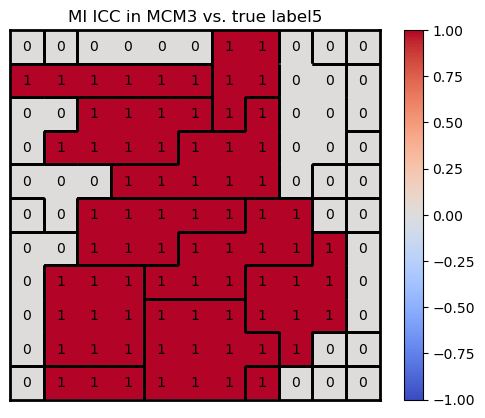

In [83]:
#  mutual information between MI(estimated_PDF, TRUE)
from sklearn.feature_selection import mutual_info_regression
for cls in [3,5]:
    P_m3_c3 = all_P_icc[:,:,cls]

    nr_comms = np.max(comms)+1
    nr_datapoints = len(P_m3_c3[0,:])
    labels =np.ones(nr_datapoints) if cls ==3 else np.zeros(nr_datapoints)
    out = np.zeros(nr_comms)
    for i in range(nr_comms):
        out[i]=normalized_mutual_info_score(np.where(P_m3_c3[i,:]>=0.5,1,0),labels)
    out

    # mi_matrix = (out[comms]*1000).astype(int)
    mi_matrix = out[comms].astype(int)
    absmax = np.abs(mi_matrix.flat[np.abs(mi_matrix).argmax()])

    plt.figure()
    plt.title(f"MI ICC in MCM3 vs. true label{cls}")
    myplot.draw_all_borders(borders)
    # r = (np.mean(bias)+np.std(bias))
    # drawing_cond = lambda x: np.abs(x) > r
    drawing_cond = lambda x: True
    myplot.draw_all_values(mi_matrix,color="black",cond=drawing_cond) # bias OR comms
    # white_map = myplot.create_white_cmap()
    im = plt.imshow(mi_matrix, cmap="coolwarm", vmin=-absmax,vmax=absmax)  # Set the color limits
    colorbar = plt.colorbar(im)

    plt.xticks([])
    plt.yticks([])
    plt.setp(plt.gca().spines.values(), linewidth=2)

    plt.show()

# NEXT: MI of ICC vote vs correct vote

In [ ]:
# need a co-occurance matrix of what it was called
# 121 by 121 of how destinctive that pixel is between 3 vs. 5

# 1 matrix = 1 image
# what icc these pixels are part of
